# **Import Required Libraries**
This cell imports all necessary Python libraries for:
- Data preprocessing (Pandas, NumPy)
- Machine learning models (SVM, KNN, Naïve Bayes)
- Feature selection (Decision Tree)
- Hyperparameter tuning (GridSearchCV)
- Performance evaluation (Accuracy, Precision, Recall, etc.)


In [27]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **Load the Dataset**
- Fetches the Heart Disease dataset from the UCI Machine Learning Repository.
- Extracts feature variables (`X`) and the target variable (`y`).
- Converts the target variable into **binary classification**:
  - `0` → No disease
  - `1` → Disease (all non-zero values converted to `1`)


In [28]:
# Import dataset
heart_disease = fetch_ucirepo(id=45)

# Access data
X = heart_disease.data.features
y = heart_disease.data.targets

y = pd.Series(y.values.flatten(), name='target')

# Convert target variable to binary classification (0 = no disease, 1 = disease)
y = (y > 0).astype(int)  # Convert all non-zero values to 1

# **Handle Missing Values & Encode Categorical Features**
- Uses **Nearest Neighbor Hot Deck Imputation (KNN Imputer)** to fill missing values.
- Defines **numerical** and **categorical** features.
- Converts categorical columns to **integer format** after imputation.
- Applies **Label Encoding** to categorical features for model compatibility.


In [29]:
# Handle missing values using Nearest Neighbor Hot Deck Imputation (KNN)
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Define numerical and categorical features
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Convert categorical columns back to integers
X_imputed[categorical_features] = X_imputed[categorical_features].round(0).astype(int)

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_imputed[col] = le.fit_transform(X_imputed[col])
    label_encoders[col] = le  # Store encoders for later decoding if needed

# **Standardize Numerical Features**
- Applies **StandardScaler** to numerical features to normalize their values.
- Helps machine learning models perform better by ensuring all features have a **mean of 0** and **standard deviation of 1**.


In [30]:
# Standardize numerical features
scaler = StandardScaler()
X_imputed[numeric_features] = scaler.fit_transform(X_imputed[numeric_features])

# **Split Data into Training & Testing Sets**
- Splits the dataset into **70% training** and **30% testing**.
- Uses **stratified sampling** to maintain class balance in both sets.
- Sets `random_state=42` for reproducibility.


In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X_imputed, y, test_size=0.4, stratify=y, random_state=42)

# Then, split the temporary set into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# **Feature Selection Using Decision Tree**
- Trains a **Decision Tree classifier** on the training data.
- Selects the **top 7 most important features** based on feature importance scores.
- Creates a **reduced dataset** using only the selected features.


Decision Tree Selected Features: ['oldpeak', 'chol', 'age', 'ca', 'thal', 'thalach', 'cp']


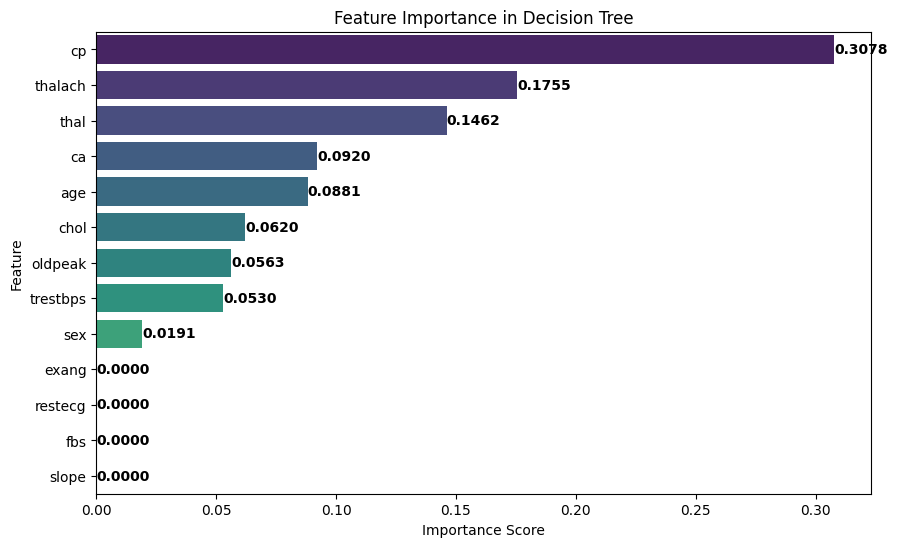

In [32]:

# Feature selection using Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
importances = dt.feature_importances_
selected_features_dt = X_train.columns[np.argsort(importances)[-7:]]  # Top 7 features

# Create reduced feature datasets for Decision Tree selection
X_train_dt = X_train[selected_features_dt]
X_test_dt = X_test[selected_features_dt]

# Print selected features
print("Decision Tree Selected Features:", selected_features_dt.tolist())

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': dt.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Sort by importance

# Plot the feature importance with updated syntax
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', hue="Feature", data=importance_df, palette='viridis', legend=False)

# Annotate bars with feature importance values
for index, value in enumerate(importance_df['Importance']):
    ax.text(value, index, f"{value:.4f}", va='center', fontsize=10, color='black', weight='bold')

plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()


# **Manually Selected Features**
- Uses a **manually chosen subset of 7 features** based on prior knowledge.
- Creates a **reduced dataset** using these features.


In [33]:
# Manually selected features
manual_selected_features = ['cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# Create reduced feature datasets for manually selected features
X_train_manual = X_train[manual_selected_features]
X_test_manual = X_test[manual_selected_features]

# Print selected features
print("Manually Selected Features:", manual_selected_features)


Manually Selected Features: ['cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


# **Train & Evaluate Models (Baseline Parameters)**
- Trains SVM, KNN, and Naïve Bayes models using parameters from the **baseline study**.
- Evaluates models using **Accuracy, Precision, Recall, F1-score, and Specificity**.
- Runs experiments on:
  - **All features**
  - **Decision Tree-selected features**
  - **Manually selected features**


In [44]:
# Function to evaluate models using Accuracy, Precision, Recall, F1-score, and Specificity
def evaluate_models(X_train, X_test, feature_type, model_dict, results):
    print(f"\nResults using {feature_type} features:")
    results[feature_type] = {}  # Create an entry for this feature selection method

    for name, model in model_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        # Print the results
        print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Specificity: {specificity:.4f}")

        # Store the results for visualization
        results[feature_type][name] = [accuracy, precision, recall, f1, specificity]


def plot_feature_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Specificity"]
    models = list(results["All Features"].keys())  # Extract model names
    feature_methods = list(results.keys())  # Feature selection methods
    
    x = np.arange(len(models))  # Model positions
    width = 0.25  # Bar width

    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
    colors = ['blue', 'green', 'orange']

    for i, metric in enumerate(metrics):
        ax = axes[i]

        for j, method in enumerate(feature_methods):
            values = [results[method][model][i] for model in models]  # Extract metric values
            ax.bar(x + j * width - width, values, width, label=method, color=colors[j])

            # Add text inside bars
            for k, v in enumerate(values):
                ax.text(k + j * width - width, v + 0.01, f"{v:.2f}", ha='center', fontsize=10, color='black', weight='bold')

        ax.set_title(metric)
        ax.set_xticks(x + width / 2)
        ax.set_xticklabels(models, rotation=45)

        # Set legend position at the bottom
        ax.legend(loc="lower left", fontsize=10)

    plt.suptitle("Comparison of Feature Selection Methods Across Models")
    plt.show()


Results using All Features features:
SVM - Accuracy: 0.8197, Precision: 0.7742, Recall: 0.8571, F1-score: 0.8136, Specificity: 0.7879
KNN - Accuracy: 0.7705, Precision: 0.7188, Recall: 0.8214, F1-score: 0.7667, Specificity: 0.7273
Naïve Bayes - Accuracy: 0.9016, Precision: 0.8667, Recall: 0.9286, F1-score: 0.8966, Specificity: 0.8788

Results using Decision Tree features:
SVM - Accuracy: 0.7869, Precision: 0.7419, Recall: 0.8214, F1-score: 0.7797, Specificity: 0.7576
KNN - Accuracy: 0.7541, Precision: 0.6970, Recall: 0.8214, F1-score: 0.7541, Specificity: 0.6970
Naïve Bayes - Accuracy: 0.8852, Precision: 0.8387, Recall: 0.9286, F1-score: 0.8814, Specificity: 0.8485

Results using Manual Selection features:
SVM - Accuracy: 0.8197, Precision: 0.7931, Recall: 0.8214, F1-score: 0.8070, Specificity: 0.8182
KNN - Accuracy: 0.8361, Precision: 0.8214, Recall: 0.8214, F1-score: 0.8214, Specificity: 0.8485
Naïve Bayes - Accuracy: 0.8033, Precision: 0.7667, Recall: 0.8214, F1-score: 0.7931, Spec

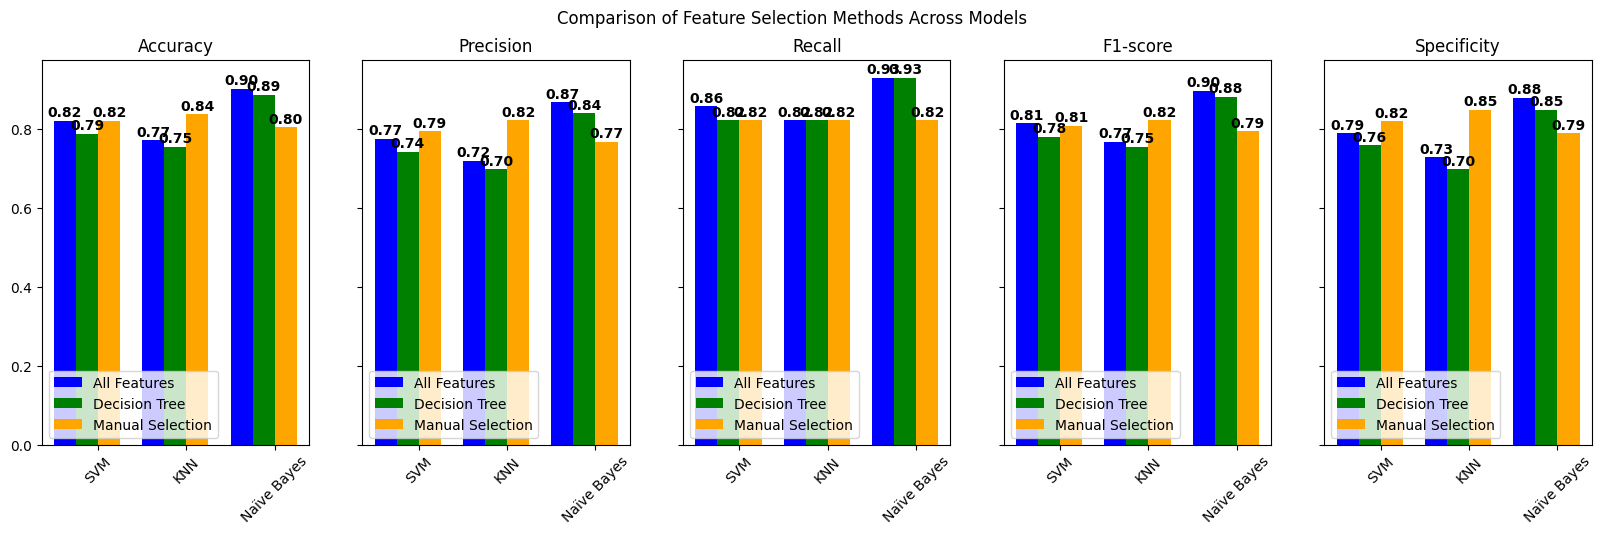

In [45]:
models_baseline = {
    "SVM": SVC(C=0.25, kernel='rbf', gamma=0.1268408),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naïve Bayes": GaussianNB(var_smoothing=1e-9)
}

results = {"All Features": {}, "Decision Tree": {}, "Manual Selection": {}}

evaluate_models(X_train, X_test, "All Features", models_baseline,results)
evaluate_models(X_train_dt, X_test_dt, "Decision Tree", models_baseline,results)
evaluate_models(X_train_manual, X_test_manual, "Manual Selection", models_baseline, results)
plot_feature_comparison(results)

# **Hyperparameter Tuning with GridSearchCV**
- Optimizes **SVM, KNN, and Naïve Bayes** models using **GridSearchCV**.
- Runs experiments on:
  - **All features**
  - **Decision Tree-selected features**
  - **Manually selected features**


In [46]:
# Define parameter grid BEFORE calling train_with_gridsearch
param_grid = {
    "SVM": {"C": [0.25, 0.5, 1.0], "gamma": [0.1268408, 'scale', 'auto'], "kernel": ['rbf']},
    "KNN": {"n_neighbors": [5, 7, 9]},
    "Naïve Bayes": {"var_smoothing": [1e-9, 1e-8, 1e-7]}
}

# Function to train models using GridSearchCV and store results
def train_with_gridsearch(X_train, X_test, feature_type):
    print(f"\nResults using {feature_type} features with GridSearchCV:")
    
    results = {}  # Dictionary to store results

    for name, param in param_grid.items():
        if name == "SVM":
            model = SVC()
        elif name == "KNN":
            model = KNeighborsClassifier()
        elif name == "Naïve Bayes":
            model = GaussianNB()
        
        grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        print(f"{name} - Best Params: {grid_search.best_params_}")
        print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
              f"F1-score: {f1:.4f}, Specificity: {specificity:.4f}\n")

        results[name] = [accuracy, precision, recall, f1, specificity]  # Store results

    return results  # Return collected results


Results using All Features features with GridSearchCV:
SVM - Best Params: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Accuracy: 0.8033, Precision: 0.7857, Recall: 0.7857, F1-score: 0.7857, Specificity: 0.8182

KNN - Best Params: {'n_neighbors': 5}
KNN - Accuracy: 0.7705, Precision: 0.7188, Recall: 0.8214, F1-score: 0.7667, Specificity: 0.7273

Naïve Bayes - Best Params: {'var_smoothing': 1e-09}
Naïve Bayes - Accuracy: 0.9016, Precision: 0.8667, Recall: 0.9286, F1-score: 0.8966, Specificity: 0.8788


Results using Decision Tree features with GridSearchCV:
SVM - Best Params: {'C': 1.0, 'gamma': 0.1268408, 'kernel': 'rbf'}
SVM - Accuracy: 0.7705, Precision: 0.7333, Recall: 0.7857, F1-score: 0.7586, Specificity: 0.7576

KNN - Best Params: {'n_neighbors': 9}
KNN - Accuracy: 0.7705, Precision: 0.7333, Recall: 0.7857, F1-score: 0.7586, Specificity: 0.7576

Naïve Bayes - Best Params: {'var_smoothing': 1e-09}
Naïve Bayes - Accuracy: 0.8852, Precision: 0.8387, Recall: 0.9286, F1-score: 0

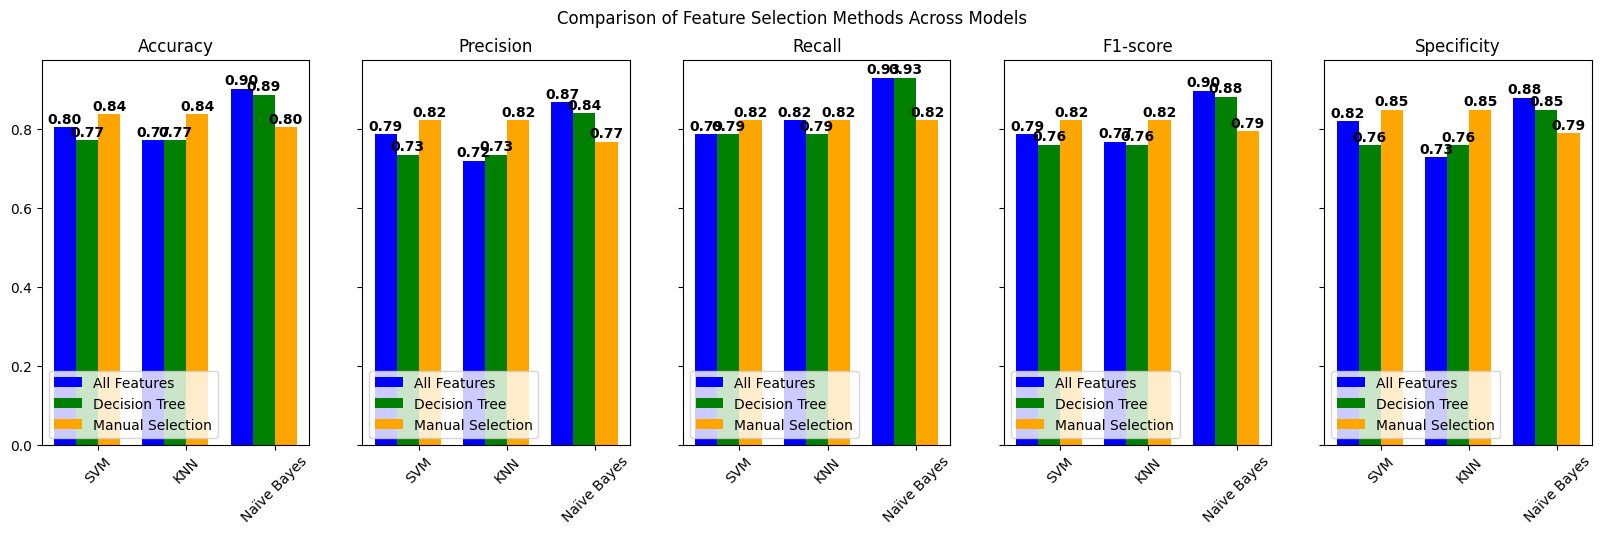

In [47]:
gridsearch_results = {
    "All Features": train_with_gridsearch(X_train, X_test, "All Features"),
    "Decision Tree": train_with_gridsearch(X_train_dt, X_test_dt, "Decision Tree"),
    "Manual Selection": train_with_gridsearch(X_train_manual, X_test_manual, "Manual Selection")
}

plot_feature_comparison(gridsearch_results)